In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import brown
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

from attention import AttentionLayer

In [2]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [3]:
train_data = pd.read_excel('train.xlsx')
test_data = pd.read_excel('evaluation.xlsx')

In [4]:
train_data.head()

,text,reason,label
0,this is an amazing app for online classes!but,good app for conducting online classes,1.0
1,very practical and easy to use,app is user-friendly,1.0
2,this app is very good for video conferencing.,good for video conferencing,1.0
3,i can not download this zoom app,unable to download zoom app,1.0
4,i am not able to download this app,want to download the app,1.0


In [46]:
test_data.head()

,text,reason,label
0,the app is crashing when i play a vedio,app crashes during playback,1.0
1,but i want to connect it to the tv from one device to another,want compatibility with more smart televisions,0.0
2,very helpful when and home working remotley,good app for work,0.0
3,this zoom so called and missed call and mobile number,receiving incorrect phone number message,0.0
4,one of my favorite apps,good for spending time,0.0


In [5]:
snli_data = pd.read_csv('/home/rohit/datasets/SNLI_1.0/snli_1.0_dev.csv')

In [6]:
snli_data.shape

(10000, 14)

In [7]:
# snli_data.head()

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [10]:
#call the function
cleaned_text = []
for t in train_data['text']:
    cleaned_text.append(text_cleaner(t,0)) 

In [11]:
len(cleaned_text)

2061

In [50]:
#test_data
test_clean_text = []
for t in test_data['text']:
    test_clean_text.append(text_cleaner(t,0)) 

In [53]:
test_clean_text

['app crashing play vedio',
 'want connect tv one device another',
 'helpful home working remotley',
 'zoom called missed call mobile number',
 'one favorite apps',
 'enjoyed watching favorite shows movies',
 'internet month half watch turktelekom bisey',
 'great app download video video playing offline without adds',
 'excellent app video conferencing drawback ipad pro almost pc create rooms',
 'also continue watching left',
 'sorry say small issue takes one half month resolve bad service one continue zoom',
 'issues getting resolved',
 'let play movies',
 'love much watch family kids dramas',
 'learn tips tricks recording podcast episode remotely',
 'zoom useful home school meetings home',
 'good application great say network bothering',
 'watching tv moments ads become problem like mobile app',
 'good meetings',
 'reactivate subscription please',
 'app works well use talk friends fulfills purpose',
 'enjoyed benefits program jehovah witness worldwide thank wonderful program joined u

In [12]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in train_data['reason']:
    cleaned_summary.append(summary_cleaner(t))

train_data['cleaned_text']=cleaned_text
train_data['cleaned_summary']=cleaned_summary
train_data['cleaned_summary'].replace('', np.nan, inplace=True)
train_data.dropna(axis=0,inplace=True)

In [13]:
train_data['cleaned_summary'] = train_data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [52]:
test_cleaned_summary = []
for t in test_data['reason']:
    test_cleaned_summary.append(summary_cleaner(t))

In [54]:
test_cleaned_summary

['app crashes during playback ',
 'want compatibility with more smart televisions ',
 'good app for work ',
 'receiving incorrect phone number message ',
 'good for spending time ',
 'good to watch shows ',
 'unable to access live tv ',
 'good app to download videos ',
 'want to record on ipad ',
 'unable to sync watched episodes ',
 'zoom server crashes ',
 'want to contact technical support ',
 'unable to view all movies ',
 'good to watch shows ',
 'want to record audio when not the host ',
 'good app for students ',
 'facing network issues with app ',
 'getting ads frequently ',
 'good app for conducting online meeting ',
 'unable to unsubscribe ',
 'good for family and friends ',
 'good app for conducting online meeting ',
 'app is good to watch disney content ',
 'good for watching movies and serials ',
 'app is not good ',
 'reinstalling did not work ',
 'want to enter breakout room ',
 'app is not working after latest update ',
 'unable to use streaming service ',
 'app subscri

In [14]:
for i in range(5):
    print("Review:",train_data['cleaned_text'][i])
    print("Summary:",train_data['cleaned_summary'][i])
    print("\n")

Review: amazing app online classes
Summary: _START_ good app for conducting online classes  _END_


Review: practical easy use
Summary: _START_ app is user friendly  _END_


Review: app good video conferencing
Summary: _START_ good for video conferencing  _END_


Review: download zoom app
Summary: _START_ unable to download zoom app  _END_


Review: able download app
Summary: _START_ want to download the app  _END_




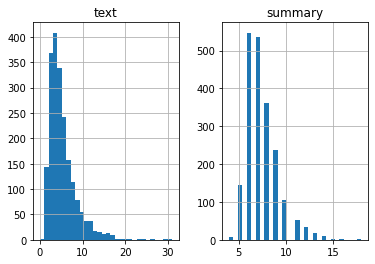

In [15]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in train_data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in train_data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [16]:
ct = train_data['cleaned_text'].values
max_text_len = max([len(x) for x in ct])
avg_text_len = sum([len(x) for x in ct])/len(ct)
avg_text_len

37.46482290150412

In [17]:
max_text_len

209

In [18]:
ct = train_data['cleaned_summary'].values
max_summary_len = max([len(x) for x in ct])

avg_sum_len = sum([len(x) for x in ct])/len(ct)
avg_sum_len

45.6045608927705

In [19]:
max_text_len=80 
max_len_summary=70

In [20]:

cleaned_text =np.array(train_data['cleaned_text'])
cleaned_summary=np.array(train_data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [21]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [22]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [23]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [24]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 72.97551789077212
Total Coverage of rare words: 21.159587787729944


In [25]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [55]:
#test_clean_text
X_test_text = x_tokenizer.texts_to_sequences(test_clean_text)
X_test_ = pad_sequences(X_test_text,  maxlen=max_text_len, padding='post')

In [26]:
x_voc

575

In [27]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [28]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.73163186388244
Total Coverage of rare words: 9.991988096600664


In [29]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [56]:
#test_cleaned_summary

Y_test = y_tokenizer.texts_to_sequences(test_cleaned_summary) 


ValueError: invalid literal for int() with base 10: 'app crashes during playback '

In [58]:
Y_test_ = pad_sequences(Y_test, maxlen=max_len_summary, padding='post')

In [30]:
y_tokenizer.num_words

In [31]:
#size of vocabulary
y_voc  =   len(y_tokenizer.word_index) +1

In [36]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 100)      57500       input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [39]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=16, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
116/116 [==============================] - 83s 668ms/step - loss: 0.6580 - val_loss: 0.4110
Epoch 2/50
116/116 [==============================] - 77s 668ms/step - loss: 0.4186 - val_loss: 0.3741
Epoch 3/50
116/116 [==============================] - 77s 665ms/step - loss: 0.3805 - val_loss: 0.3556
Epoch 4/50
116/116 [==============================] - 77s 665ms/step - loss: 0.3584 - val_loss: 0.3434
Epoch 5/50
116/116 [==============================] - 77s 667ms/step - loss: 0.3422 - val_loss: 0.3355
Epoch 6/50
116/116 [==============================] - 78s 670ms/step - loss: 0.3299 - val_loss: 0.3337
Epoch 7/50
116/116 [==============================] - 77s 661ms/step - loss: 0.3188 - val_loss: 0.3248
Epoch 8/50
116/116 [==============================] - 77s 661ms/step - loss: 0.3088 - val_loss: 0.3187
Epoch 9/50
116/116 [==============================] - 78s 669ms/step - loss: 0.2990 - val_loss: 0.3155
Epoch 10/50
116/116 [==============================] - 77s 660ms/step - l

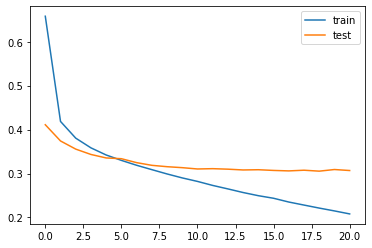

In [40]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [41]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [42]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [43]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [44]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [45]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: difficult lost time one stop game bad 
Original summary: start game needs improvement end 
Predicted summary:  start want to remove subscription end


Review: worst app online classes 
Original summary: start not perfect for online classes end 
Predicted summary:  start app is bad for online classes end


Review: know enter zoom meeting 
Original summary: start want to join meeting rooms end 
Predicted summary:  start want to access zoom room end


Review: hope add function worth 
Original summary: start want block function end 
Predicted summary:  start want to add subtitles end


Review: stars camera cannot turned microphone 
Original summary: start camera cannot be turned on separately from microphone end 
Predicted summary:  start want to change the app end


Review: sometimes episode 
Original summary: start unable to continue the episode end 
Predicted summary:  start want to connect to the conference end


Review: problem screen 
Original summary: start facing issues wit

Predicted summary:  start poor quality of service end


Review: application open device 
Original summary: start unable to open on redmi note end 
Predicted summary:  start app crashes frequently end


Review: star background blur 
Original summary: start want blurred background feature end 
Predicted summary:  start want to add background option end


Review: look section try watch show load episodes 
Original summary: start unable to load videos in my stuff list end 
Predicted summary:  start app is bad to load end


Review: know cancel service payment becomes automatic 
Original summary: start want to cancel subscription end 
Predicted summary:  start want to connect to high end


Review: class app option update 
Original summary: start want to update end 
Predicted summary:  start want to use the app end


Review: app working android devices 
Original summary: start unable to load the android app end 
Predicted summary:  start unable to use on android tv end


Review: internet conn

In [47]:
x_tr[i]

array([ 56,   9,  28,   1,  17, 399,  43,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [48]:
y_tr[i]

array([  3,   1,  41, 173,  29, 193,   2,   4,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0], dtype=int32)

In [59]:
X_test_[0]

array([  1, 427, 108,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [60]:
Y_test_[0]

array([  7,  93, 104, 285,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0], dtype=int32)

In [83]:
original = []
predicted = []
for i in range(0,8000):
    #print("Review:",seq2text(X_test_[i]))
    #print("Original summary:",seq2summary(Y_test_[i]))
    original.append(seq2summary(Y_test_[i]))
    #print("Predicted summary:",decode_sequence(X_test_[i].reshape(1,max_text_len)))
    predicted.append(decode_sequence(X_test_[i].reshape(1,max_text_len)))
    #print("\n")

In [84]:
from rouge_score import rouge_scorer

# scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
# scores = scorer.score('The quick brown fox jumps over the lazy dog',
#                       'The quick brown dog jumps on the log.')

In [74]:
scores

{'rougeL': Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)}

In [85]:
rougeL = []
scorer = rouge_scorer.RougeScorer(['rougeL'])
for i in range(len(original)):
    rougeL.append(scorer.score(original[i],predicted[i])['rougeL'].fmeasure)

In [86]:
len(rougeL)

8000

In [81]:
test_data.head(100)

,text,reason,label
0,the app is crashing when i play a vedio,app crashes during playback,1.0
1,but i want to connect it to the tv from one device to another,want compatibility with more smart televisions,0.0
2,very helpful when and home working remotley,good app for work,0.0
3,this zoom so called and missed call and mobile number,receiving incorrect phone number message,0.0
4,one of my favorite apps,good for spending time,0.0
...,...,...,...
95,"so, it is good and all but for some reason every time i try to close the small zoom window, it reopens zoom entirely instead of closing the small window so yeah, 4 stars",zoom has a time limit,0.0
96,best streaming service especially for marvel and disney/pixar fans,best streaming service,1.0
97,cannot get zoom to connect to my camera,want to connect to zoom,0.0
98,cannot launch the application on my s21 ultra (error 83).,unable to use app,1.0


In [105]:
predict_res = []
for i in range(len(rougeL)):
    if rougeL[i] > 0.13:
        predict_res.append(1)
    else:
        predict_res.append(0)
        
    
        

In [97]:
from sklearn.metrics import classification_report,roc_auc_score
y_true = test_data['label'].values

print(classification_report(y_true[:8000],predict_res))

              precision    recall  f1-score   support

         0.0       0.68      0.88      0.77      5335
         1.0       0.40      0.16      0.23      2665

    accuracy                           0.64      8000
   macro avg       0.54      0.52      0.50      8000
weighted avg       0.59      0.64      0.59      8000



In [98]:


-

0.5210681699492361

In [93]:
from sklearn.metrics import classification_report,roc_auc_score
y_true = test_data['label'].values

print(classification_report(y_true[:8000],predict_res))

              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      5335
         1.0       0.37      0.37      0.37      2665

    accuracy                           0.58      8000
   macro avg       0.52      0.52      0.52      8000
weighted avg       0.58      0.58      0.58      8000



In [95]:
#for 0.3
roc_auc_score(y_true[:8000],predict_res)

0.5210681699492361

In [90]:
from sklearn.metrics import classification_report,roc_auc_score
y_true = test_data['label'].values

print(classification_report(y_true[:8000],predict_res))

              precision    recall  f1-score   support

         0.0       0.69      0.61      0.65      5335
         1.0       0.37      0.45      0.40      2665

    accuracy                           0.56      8000
   macro avg       0.53      0.53      0.53      8000
weighted avg       0.58      0.56      0.57      8000



In [91]:
#for 0.2
roc_auc_score(y_true[:8000],predict_res)

0.5302000488824729

In [100]:
from sklearn.metrics import classification_report,roc_auc_score
y_true = test_data['label'].values

print(classification_report(y_true[:8000],predict_res))

              precision    recall  f1-score   support

         0.0       0.72      0.42      0.53      5335
         1.0       0.37      0.67      0.47      2665

    accuracy                           0.50      8000
   macro avg       0.54      0.55      0.50      8000
weighted avg       0.60      0.50      0.51      8000



In [101]:
#for 0.15
roc_auc_score(y_true[:8000],predict_res)

0.5460504544487446

In [103]:
from sklearn.metrics import classification_report,roc_auc_score
y_true = test_data['label'].values

print(classification_report(y_true[:8000],predict_res))

              precision    recall  f1-score   support

         0.0       0.72      0.37      0.49      5335
         1.0       0.36      0.71      0.48      2665

    accuracy                           0.48      8000
   macro avg       0.54      0.54      0.48      8000
weighted avg       0.60      0.48      0.48      8000



In [104]:
#for 0.10
roc_auc_score(y_true[:8000],predict_res)

0.5397899812031066

In [106]:
from sklearn.metrics import classification_report,roc_auc_score
y_true = test_data['label'].values

print(classification_report(y_true[:8000],predict_res))

              precision    recall  f1-score   support

         0.0       0.72      0.38      0.50      5335
         1.0       0.36      0.70      0.48      2665

    accuracy                           0.49      8000
   macro avg       0.54      0.54      0.49      8000
weighted avg       0.60      0.49      0.49      8000



In [107]:
#for 0.13
roc_auc_score(y_true[:8000],predict_res)

0.5440976172432044